In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline

from IPython.display import display, HTML

In [3]:
relevance_train = pd.read_csv('relevance_train.csv', sep='\t')
relevance_test = pd.read_csv('relevance_test.csv')
queries = pd.read_csv('queries.csv', index_col="QueryId")

In [4]:
display(relevance_train.head(10))
display(relevance_test.head(1))
display(queries.head(5))
print(relevance_test.QueryId.max(),relevance_test.DocumentId.max())

,QueryId,DocumentId,Relevance
0,1,184,2
1,1,29,2
2,1,31,2
3,1,12,3
4,1,51,3
5,1,102,3
6,1,13,4
7,1,14,4
8,1,15,4
9,1,57,2


,QueryId,DocumentId
0,126,974


,Query
QueryId,
1,what similarity laws must be obeyed when const...
2,what are the structural and aeroelastic proble...
4,what problems of heat conduction in composite ...
8,can a criterion be developed to show empirical...
9,what chemical kinetic system is applicable to ...


225 1400


In [5]:
relevance_train[relevance_train.QueryId == 3]

,QueryId,DocumentId,Relevance
54,3,5,3
55,3,6,3
56,3,90,3
57,3,91,3
58,3,119,3
59,3,144,3
60,3,181,3
61,3,399,3
62,3,485,-1


In [6]:
documents = []

with open('Documents.csv', 'r') as f:
    for line in f:
        if line.startswith(".Id "):
            documents.append([int(line[4:]), ""])
        else:
            documents[-1][1] += line
            
documents = dict(documents)

Поюзаем nltk

In [7]:

import nltk
import sys
import os
from math import log
import numpy as np
from time import time
from gensim import corpora, models, similarities

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#nltk.download() #download WordNet corpora



In [13]:
import string
punct_remover = str.maketrans(string.punctuation, ' '*len(string.punctuation))

def preprocess(text):
    wnl = nltk.WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in text.lower().translate(punct_remover).split()]

In [14]:
texts = []
texts_ids = []
for text_id, text in documents.items():
    texts.append(preprocess(text))
    texts_ids.append(text_id)

In [15]:
texts = []
texts_ids = []
text_id_to_pos = {}
for text_id, text in documents.items():
    texts.append(preprocess(text))
    text_id_to_pos[text_id] = len(texts_ids)
    texts_ids.append(text_id)

In [16]:
dictionary = corpora.Dictionary(texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.5, keep_n=None)
dictionary.save('nips.dict')
print('Filtered: {}'.format(dictionary))

2017-12-02 23:29:28,329 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-02 23:29:28,496 : INFO : built Dictionary(8593 unique tokens: ['complex', 'preferable', 'interacted', 'rendered', 'fujihiko']...) from 1400 documents (total 262517 corpus positions)
2017-12-02 23:29:28,515 : INFO : discarding 5991 tokens: [('the', 1391), ('of', 1395), ('to', 1257), ('flow', 729), ('destalling', 2), ('for', 1145), ('t', 1400), ('an', 796), ('a', 1400), ('that', 807)]...
2017-12-02 23:29:28,516 : INFO : keeping 2602 tokens which were in no less than 5 and no more than 700 (=50.0%) documents
2017-12-02 23:29:28,520 : INFO : resulting dictionary: Dictionary(2602 unique tokens: ['nonsteady', 'complex', 'into', 'will', 'portion']...)
2017-12-02 23:29:28,522 : INFO : saving Dictionary object under nips.dict, separately None
2017-12-02 23:29:28,525 : INFO : saved nips.dict


Original: Dictionary(8593 unique tokens: ['complex', 'preferable', 'interacted', 'rendered', 'fujihiko']...)
Filtered: Dictionary(2602 unique tokens: ['nonsteady', 'complex', 'into', 'will', 'portion']...)


In [17]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
list(dictionary.items())[:10]


[(0, 'nonsteady'),
 (1, 'complex'),
 (2, 'into'),
 (3, 'will'),
 (2172, 'portion'),
 (5, 'produced'),
 (6, 'usual'),
 (444, 'induced'),
 (9, 'wire'),
 (10, 'system')]

In [19]:
print(corpus[0][0:20])

[(5, 1), (100, 1), (132, 2), (156, 1), (161, 1), (169, 3), (179, 2), (205, 1), (236, 1), (327, 1), (356, 1), (409, 4), (426, 1), (448, 1), (531, 1), (534, 1), (543, 1), (554, 1), (574, 1), (611, 2)]


In [20]:
start = time()
model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=100, chunksize=50, update_every=1, passes=2)
print('Evaluation time: {}'.format((time()-start) / 60))

2017-12-02 23:29:29,998 : INFO : using symmetric alpha at 0.01
2017-12-02 23:29:30,003 : INFO : using symmetric eta at 0.0003843197540353574
2017-12-02 23:29:30,005 : INFO : using serial LDA version on this node
2017-12-02 23:29:32,677 : INFO : running online (multi-pass) LDA training, 100 topics, 2 passes over the supplied corpus of 1400 documents, updating model once every 50 documents, evaluating perplexity every 500 documents, iterating 50x with a convergence threshold of 0.001000
2017-12-02 23:29:32,678 : INFO : PROGRESS: pass 0, at document #50/1400
2017-12-02 23:29:33,332 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:33,489 : INFO : topic #15 (0.010): 0.087*"boundary" + 0.087*"layer" + 0.054*"incompressible" + 0.049*"plate" + 0.040*"solution" + 0.038*"shear" + 0.037*"laminar" + 0.031*"equation" + 0.030*"approximate" + 0.020*"steady"
2017-12-02 23:29:33,490 : INFO : topic #45 (0.010): 0.041*"slipstream" + 0.030*"lift" + 0.024*"wa" + 0.

2017-12-02 23:29:36,688 : INFO : topic #62 (0.010): 0.216*"ratio" + 0.092*"presence" + 0.051*"studied" + 0.050*"field" + 0.039*"advantage" + 0.035*"conducting" + 0.031*"magnetic" + 0.031*"chart" + 0.029*"even" + 0.024*"current"
2017-12-02 23:29:36,689 : INFO : topic diff=1.954456, rho=0.408248
2017-12-02 23:29:36,691 : INFO : PROGRESS: pass 0, at document #350/1400
2017-12-02 23:29:37,053 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:37,155 : INFO : topic #32 (0.010): 0.127*"vorticity" + 0.090*"incompressible" + 0.082*"shear" + 0.071*"inviscid" + 0.046*"effect" + 0.044*"approximate" + 0.039*"fluid" + 0.035*"two" + 0.034*"layer" + 0.032*"equation"
2017-12-02 23:29:37,155 : INFO : topic #23 (0.010): 0.080*"body" + 0.046*"hypersonic" + 0.030*"blunt" + 0.028*"or" + 0.026*"than" + 0.021*"small" + 0.020*"past" + 0.018*"which" + 0.018*"expansion" + 0.017*"disturbance"
2017-12-02 23:29:37,156 : INFO : topic #25 (0.010): 0.250*"jet" + 0.065*"vortex" 

2017-12-02 23:29:40,937 : INFO : topic #77 (0.010): 0.296*"compressor" + 0.291*"stage" + 0.070*"blade" + 0.046*"rotor" + 0.032*"turbine" + 0.026*"cascade" + 0.022*"efficiency" + 0.021*"row" + 0.019*"phase" + 0.016*"80"
2017-12-02 23:29:40,938 : INFO : topic diff=1.116809, rho=0.288675
2017-12-02 23:29:40,939 : INFO : PROGRESS: pass 0, at document #650/1400
2017-12-02 23:29:41,316 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:41,399 : INFO : topic #11 (0.010): 0.205*"highly" + 0.196*"flap" + 0.136*"history" + 0.055*"comment" + 0.050*"underlying" + 0.036*"followed" + 0.034*"press" + 0.028*"350" + 0.026*"referred" + 0.025*"unified"
2017-12-02 23:29:41,400 : INFO : topic #2 (0.010): 0.057*"modification" + 0.056*"correlated" + 0.049*"show" + 0.047*"generalised" + 0.047*"pointed" + 0.041*"figure" + 0.041*"support" + 0.035*"200" + 0.033*"specific" + 0.030*"expressed"
2017-12-02 23:29:41,401 : INFO : topic #58 (0.010): 0.094*"v" + 0.076*"three" + 0.

2017-12-02 23:29:43,692 : INFO : topic diff=0.608943, rho=0.235702
2017-12-02 23:29:43,693 : INFO : PROGRESS: pass 0, at document #950/1400
2017-12-02 23:29:44,089 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:44,170 : INFO : topic #82 (0.010): 0.152*"review" + 0.124*"attempt" + 0.096*"located" + 0.080*"against" + 0.070*"distributed" + 0.065*"metal" + 0.056*"plot" + 0.054*"aeronautics" + 0.041*"airstream" + 0.040*"especially"
2017-12-02 23:29:44,171 : INFO : topic #71 (0.010): 0.114*"region" + 0.087*"length" + 0.056*"radius" + 0.053*"1961" + 0.043*"separated" + 0.036*"varied" + 0.035*"ratio" + 0.031*"portion" + 0.028*"3" + 0.025*"part"
2017-12-02 23:29:44,172 : INFO : topic #1 (0.010): 0.194*"load" + 0.078*"problem" + 0.059*"structural" + 0.056*"subjected" + 0.050*"one" + 0.045*"time" + 0.045*"thermal" + 0.040*"failure" + 0.034*"under" + 0.030*"transient"
2017-12-02 23:29:44,172 : INFO : topic #69 (0.010): 0.180*"noise" + 0.130*"altitude" + 

2017-12-02 23:29:46,808 : INFO : topic diff=0.385979, rho=0.204124
2017-12-02 23:29:46,809 : INFO : PROGRESS: pass 0, at document #1250/1400
2017-12-02 23:29:47,222 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:47,295 : INFO : topic #51 (0.010): 0.143*"thrust" + 0.126*"instability" + 0.120*"combination" + 0.088*"tested" + 0.064*"chord" + 0.062*"delta" + 0.060*"had" + 0.044*"pitch" + 0.036*"60" + 0.031*"trend"
2017-12-02 23:29:47,296 : INFO : topic #92 (0.010): 0.113*"cylinder" + 0.062*"circular" + 0.041*"order" + 0.018*"which" + 0.015*"be" + 0.015*"magnitude" + 0.014*"thickness" + 0.014*"effect" + 0.013*"these" + 0.013*"small"
2017-12-02 23:29:47,297 : INFO : topic #49 (0.010): 0.226*"stability" + 0.143*"design" + 0.100*"stiffened" + 0.075*"test" + 0.062*"short" + 0.051*"derivative" + 0.046*"rapid" + 0.034*"or" + 0.021*"use" + 0.020*"calculate"
2017-12-02 23:29:47,298 : INFO : topic #57 (0.010): 0.258*"stress" + 0.050*"thermal" + 0.041*"indi

2017-12-02 23:29:49,995 : INFO : topic diff=0.273868, rho=0.182574
2017-12-02 23:29:49,996 : INFO : PROGRESS: pass 1, at document #150/1400
2017-12-02 23:29:50,323 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:50,395 : INFO : topic #4 (0.010): 0.118*"supersonic" + 0.053*"subsonic" + 0.038*"transonic" + 0.030*"prediction" + 0.028*"no" + 0.026*"sc" + 0.026*"result" + 0.025*"ae" + 0.024*"recent" + 0.024*"method"
2017-12-02 23:29:50,402 : INFO : topic #74 (0.010): 0.106*"method" + 0.104*"m" + 0.086*"1956" + 0.062*"new" + 0.053*"discussed" + 0.050*"treatment" + 0.041*"23" + 0.040*"using" + 0.038*"proposed" + 0.036*"y"
2017-12-02 23:29:50,403 : INFO : topic #94 (0.010): 0.093*"flight" + 0.069*"condition" + 0.065*"vehicle" + 0.053*"under" + 0.049*"be" + 0.034*"material" + 0.023*"well" + 0.023*"thus" + 0.022*"applied" + 0.022*"other"
2017-12-02 23:29:50,406 : INFO : topic #45 (0.010): 0.436*"lift" + 0.189*"configuration" + 0.047*"together" + 0.045*"

2017-12-02 23:29:52,428 : INFO : topic diff=0.181490, rho=0.182574
2017-12-02 23:29:52,429 : INFO : PROGRESS: pass 1, at document #450/1400
2017-12-02 23:29:52,755 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:52,813 : INFO : topic #5 (0.010): 0.174*"injection" + 0.068*"downstream" + 0.059*"mass" + 0.038*"extension" + 0.032*"survey" + 0.030*"fully" + 0.030*"into" + 0.026*"earlier" + 0.025*"few" + 0.024*"this"
2017-12-02 23:29:52,814 : INFO : topic #19 (0.010): 0.148*"field" + 0.094*"magnetic" + 0.054*"transverse" + 0.048*"conducting" + 0.047*"convection" + 0.047*"fluid" + 0.042*"vertical" + 0.037*"free" + 0.029*"magnetohydrodynamic" + 0.027*"electrically"
2017-12-02 23:29:52,815 : INFO : topic #44 (0.010): 0.468*"gas" + 0.084*"regime" + 0.070*"research" + 0.058*"molecule" + 0.050*"reduction" + 0.031*"electric" + 0.030*"deceleration" + 0.024*"required" + 0.022*"foreign" + 0.019*"molecular"
2017-12-02 23:29:52,819 : INFO : topic #39 (0.010): 0

2017-12-02 23:29:55,512 : INFO : topic diff=0.147402, rho=0.182574
2017-12-02 23:29:55,513 : INFO : PROGRESS: pass 1, at document #750/1400
2017-12-02 23:29:55,835 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:55,889 : INFO : topic #58 (0.010): 0.138*"v" + 0.108*"parameter" + 0.070*"scale" + 0.059*"without" + 0.059*"x" + 0.037*"any" + 0.036*"position" + 0.036*"each" + 0.035*"three" + 0.033*"rather"
2017-12-02 23:29:55,890 : INFO : topic #38 (0.010): 0.061*"given" + 0.043*"calculation" + 0.034*"case" + 0.034*"be" + 0.031*"result" + 0.030*"which" + 0.029*"d" + 0.029*"method" + 0.024*"profile" + 0.024*"used"
2017-12-02 23:29:55,891 : INFO : topic #54 (0.010): 0.217*"angle" + 0.142*"attack" + 0.080*"cone" + 0.052*"zero" + 0.045*"body" + 0.041*"theory" + 0.040*"coefficient" + 0.036*"basic" + 0.035*"newtonian" + 0.032*"from"
2017-12-02 23:29:55,891 : INFO : topic #63 (0.010): 0.536*"model" + 0.074*"o" + 0.053*"1954" + 0.037*"21" + 0.035*"work" + 0

2017-12-02 23:29:58,498 : INFO : topic diff=0.123968, rho=0.182574
2017-12-02 23:29:58,500 : INFO : PROGRESS: pass 1, at document #1050/1400
2017-12-02 23:29:58,757 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:29:58,821 : INFO : topic #47 (0.010): 0.195*"external" + 0.168*"arbitrary" + 0.155*"second" + 0.109*"step" + 0.054*"permit" + 0.053*"requirement" + 0.049*"product" + 0.048*"first" + 0.028*"combustion" + 0.023*"flux"
2017-12-02 23:29:58,823 : INFO : topic #17 (0.010): 0.125*"elastic" + 0.059*"unsteady" + 0.055*"steady" + 0.047*"normal" + 0.046*"property" + 0.041*"procedure" + 0.032*"use" + 0.031*"application" + 0.026*"expansion" + 0.025*"thickness"
2017-12-02 23:29:58,824 : INFO : topic #91 (0.010): 0.112*"constant" + 0.063*"assumed" + 0.063*"it" + 0.043*"radial" + 0.043*"assumption" + 0.033*"be" + 0.030*"will" + 0.028*"or" + 0.027*"semi" + 0.027*"property"
2017-12-02 23:29:58,825 : INFO : topic #7 (0.010): 0.203*"from" + 0.086*"sonic" + 

2017-12-02 23:30:00,986 : INFO : PROGRESS: pass 1, at document #1350/1400
2017-12-02 23:30:01,372 : INFO : merging changes from 50 documents into a model of 1400 documents
2017-12-02 23:30:01,429 : INFO : topic #10 (0.010): 0.364*"hypersonic" + 0.142*"viscous" + 0.079*"over" + 0.070*"inviscid" + 0.043*"similarity" + 0.036*"induced" + 0.030*"interaction" + 0.030*"freestream" + 0.027*"soc" + 0.024*"cause"
2017-12-02 23:30:01,430 : INFO : topic #54 (0.010): 0.240*"angle" + 0.166*"cone" + 0.116*"attack" + 0.048*"coefficient" + 0.042*"newtonian" + 0.036*"body" + 0.035*"zero" + 0.032*"theory" + 0.028*"from" + 0.023*"tn"
2017-12-02 23:30:01,431 : INFO : topic #88 (0.010): 0.187*"through" + 0.168*"dynamic" + 0.137*"type" + 0.100*"system" + 0.083*"damping" + 0.070*"oscillation" + 0.059*"mass" + 0.034*"oscillatory" + 0.029*"r" + 0.026*"computing"
2017-12-02 23:30:01,431 : INFO : topic #33 (0.010): 0.394*"wing" + 0.180*"buckling" + 0.062*"panel" + 0.037*"distribution" + 0.036*"swept" + 0.034*"swe

Evaluation time: 0.5408106923103333


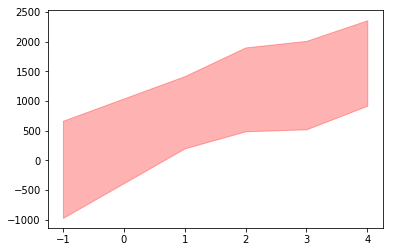

In [60]:


def upd_ww(a, b, r):
    rf = np.array(Rf)
    rf = rf / np.abs(rf).sum()
    r = rf[r + 1]

    for xa, na in a:
        for xb, nb in b:
            xab = (xa, xb)
            if xab not in ww:
                ww[xab] = 0
            ww[xab] += r
     
    
def fit_predict():
    global ar
    global br
    global ww
    
    ww = {} #  wi1, wi2 -> weight
    from collections import defaultdict
    wwd = defaultdict(lambda: 0) 
    wwq = defaultdict(lambda: 0)
    
    for index, row in relevance_train.iterrows():
        try:
            r = row.Relevance
            wwd[row.DocumentId] += r
            wwq[row.QueryId] += r
            
            text = corpus[text_id_to_pos[row.DocumentId]]
            query = dictionary.doc2bow(preprocess(queries.loc[row.QueryId].Query))
            corr_true = row.Relevance
            upd_ww(text, query, corr_true)
        except:
            #raise
            pass

    #for x in ww.keys():
    #    ww[x] = ww[x][0] / ww[x][1]

    def correl(a, b):
        s = 0
        for xa, na in a:
            for xb, nb in b:
                if (xa, xb) in ww:
                    s += ww[(xa, xb)] * nb
                if xa == xb:
                    s += 100
        return s

    ar = []
    br = []

    for index, row in relevance_train.iterrows():
        try:
            text = corpus[text_id_to_pos[row.DocumentId]]
            query = dictionary.doc2bow(preprocess(queries.loc[row.QueryId].Query))
            corr_true = row.Relevance
            
            corr = (wwd[row.DocumentId] + 0.5 * wwq[row.QueryId]) 
            corr2 = correl(text, query)
            if corr2 < -180:
                corr = -1e3
            elif corr2 > 2070:
                corr = 1e3
            else:
                corr = corr * 40 + corr2
            #corrd
            #if corr < -180:
            #    corrd
            #print(corr_true, corr)
            ar.append(corr_true)
            br.append(corr)
        except:
            pass

    ar = np.array(ar)
    br = np.array(br)


rs = [-1, 1, 2, 3, 4]
    
Rf = [-60, 0, 1, 4, 9, 30]

fit_predict()

#plt.plot(rs, [br[ar == c].sum() for c in [-1, 1, 2, 3, 4]], 'r')
plt.fill_between(rs, [br[ar == c].mean() - br[ar == c].std() for c in [-1, 1, 2, 3, 4]],
                     [br[ar == c].mean() + br[ar == c].std() for c in [-1, 1, 2, 3, 4]], color='r', alpha=0.3)

# Rf = [-1000, 0, 1, 4, 9, 800]

# fit_predict()

# plt.fill_between(rs, [br[ar == c].mean() - br[ar == c].std() for c in [-1, 1, 2, 3, 4]],
#                      [br[ar == c].mean() + br[ar == c].std() for c in [-1, 1, 2, 3, 4]], color='b', alpha=0.3)
plt.show()

In [66]:
relevance_test["Relevance"] = [0 for i in range(len(relevance_test))]

for index, row in relevance_test.iterrows():
    try:
        text = corpus[text_id_to_pos[row.DocumentId]]
        query = dictionary.doc2bow(preprocess(queries.loc[row.QueryId].Query))
        corr_true = row.Relevance

        corr = (wwd[row.DocumentId] + 0.5 * wwq[row.QueryId]) 
        corr2 = correl(text, query)
        if corr2 < -180:
            corr = -1e3
        elif corr2 > 2070:
            corr = 1e4
        else:
            corr = corr * 40 + corr2
        row.Relevance = corr
    except:
        #raise
        pass
    
relevance_test.sort_values(by="Relevance", ascending=False, inplace=True)
relevance_test.drop(["Relevance"], axis=1, inplace=True)

relevance_test.to_csv("result.csv", index=False)

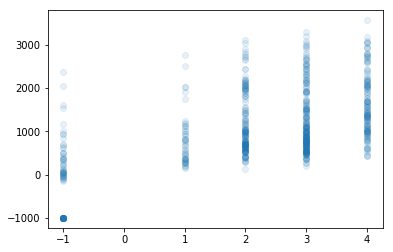

In [65]:
plt.scatter(ar, br, alpha=0.1)
plt.show()

In [56]:
print(br[ar != 4].max())

2060.81730769
